In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
# define helper functions for mse_loss
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def rho(z):
    return 2 * sigmoid(z) - 1

def myPerceptron(X, y, eta=1.0, max_iters=1000, shuffle=False, pocket=False, random_seed=None, mse_loss=False, eps=1e-6):
    """
    X = covariate matrix
    y = labels
    eta = learning rate
    max_iters = max iterations
    mse_loss = whether or not to use MSE loss function
    """
    X = np.column_stack((np.ones(X.shape[0]), X)) # add intercept column for X
    weights = np.ones(X.shape[1])   # initialize weights
    misclassification_rates = []    # initialize misclass rates
    average_costs = []              # initialize avg cost 
    n = len(y)  
    best_err = np.inf

    # run through epochs
    for epoch in range(max_iters):
        # shuffle if specified
        if shuffle:
            if random_seed is not None:
                np.random.seed(random_seed)
            idx = np.random.permutation(n)  # shuffle indices
            X, y = X[idx], y[idx]  # apply shuffle

        misclassification_count = 0     # count misclassified points
        total_cost = 0                  # store cost calcs

        #iterate through data points
        for i in range(n):
            z = np.dot(weights, X[i]) # calculate prediction

            # update weights
            if mse_loss:
                # calculate gradient
                gradient = 4*(rho(z) - y[i])*sigmoid(z)*(1 - sigmoid(z))*X[i]

                # apply SGD update rule
                weights -= eta * gradient

                # calculate square error
                total_cost += (rho(z) - y[i]) ** 2

            # normal perception
            else:
                prediction = np.sign(z)
                if prediction != y[i]:
                    weights += eta*y[i]*X[i]
                    misclassification_count += 1


        if not mse_loss:
            misclassification_rate = misclassification_count/n
            misclassification_rates.append(misclassification_rate)
        else:
            avg_cost = total_cost/n
            average_costs.append(avg_cost)
        
        # stop when misclassification_count is zero
        if not mse_loss and misclassification_count == 0:
            break

        if pocket:
            if misclassification_rate < best_err:
                best_err = misclassification_rate
                # save model coeffs
                best_weights = weights.copy()
    
    if pocket:
        return best_weights, best_err
    if mse_loss:
        return weights, average_costs

    return weights, misclassification_rates

### Problem 1
#### 1-A: Dataset Preparation

In [3]:
# Load the iris dataset
data = np.loadtxt('iris.txt')
columns = ['C1', 'C2', 'C3', 'C4', 'Label']
df = pd.DataFrame(data=data, columns=columns)

# construct dataset A
dfA = df[df['Label'].isin([0,1])].copy()
dfA['Label'] = dfA['Label'].apply(lambda y: 2*y-1)

# construct dataset B
dfB = df[df['Label'].isin([1,2])].copy()
dfB['Label'] = dfB['Label'].apply(lambda y: 2*y-3)

# set up X & y for dataset A
X_A = dfA[['C1','C2']].copy().to_numpy()
y_A = dfA['Label'].copy().to_numpy()
# set up X & y for dataset B
X_B = dfB[['C1','C2']].copy().to_numpy()
y_B = dfB['Label'].copy().to_numpy()

# set up indices as helpers for later
x1_min, x1_max = 3.75, 8.5
x2_min, x2_max = 1, 5.5

#### 1-B: Dataset Scatterplots

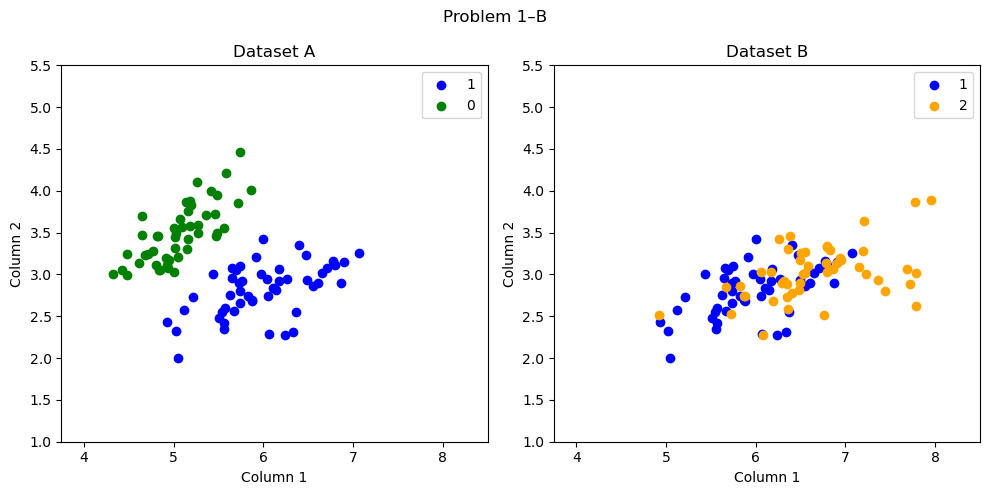

In [4]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot A
ax[0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1') # plot values labeled 1
ax[0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0') # plot values labeled -1
ax[0].set_xlabel('Column 1')
ax[0].set_ylabel('Column 2')
ax[0].legend()
ax[0].set_title('Dataset A')

# plot B
ax[1].scatter(dfB[dfB['Label']==-1]['C1'], dfB[dfB['Label']==-1]['C2'], c='blue', label='1') # plot values labeled -1
ax[1].scatter(dfB[dfB['Label']==1]['C1'], dfB[dfB['Label']==1]['C2'], c='orange', label='2') # plot values labeled 1
ax[1].set_xlabel('Column 1')
ax[1].set_ylabel('Column 2')
ax[1].legend()
ax[1].set_title('Dataset B')

# Set the same axis limits
for a in ax:
    a.set_xlim(x1_min, x1_max)
    a.set_ylim(x2_min, x2_max)

plt.suptitle('Problem 1–B')
plt.tight_layout()
plt.show()

#### 1-C: PLA on Dataset A (w/out shuffling)

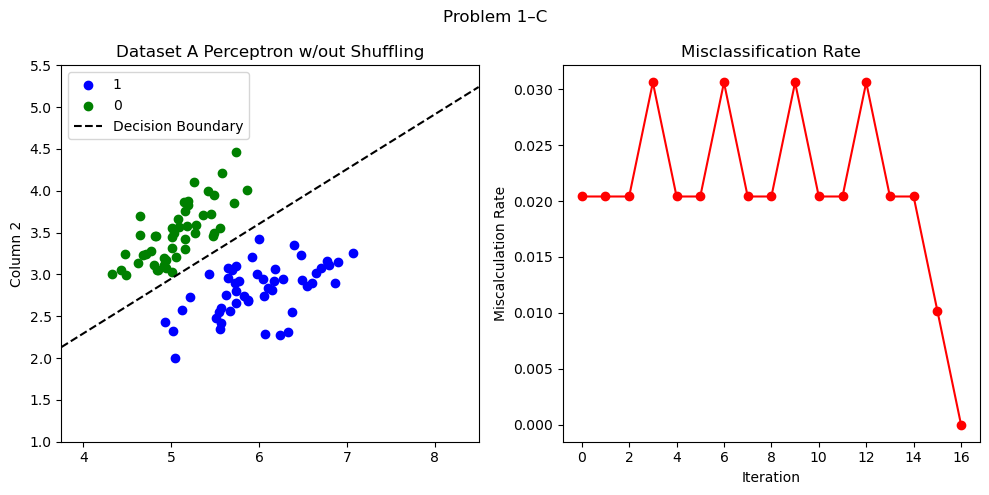

In [5]:
# initialize data
X, y = X_A.copy(), y_A.copy()

# run model
weights, errors = myPerceptron(X, y)
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2

# set up figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot dataset
ax[0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
ax[0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')
# plot decision boundary
ax[0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[0].set_ylabel('Column 2')
ax[0].legend()
ax[0].set_title('Dataset A Perceptron w/out Shuffling')
ax[0].set_xlim(x1_min, x1_max)
ax[0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[1].plot(errors, marker='o', linestyle='-', color='red')
ax[1].set_ylabel('Miscalculation Rate')
ax[1].set_xlabel('Iteration')
ax[1].set_title('Misclassification Rate')

plt.suptitle('Problem 1–C')
plt.tight_layout()
plt.show()

#### 1-D: PLA on Dataset A (w/ shuffling)

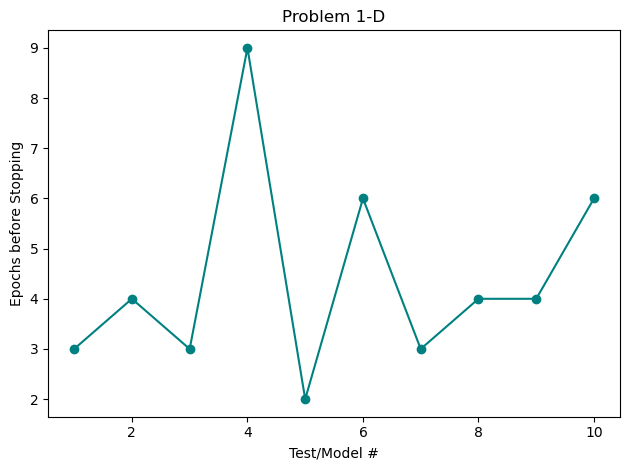

In [6]:
# initialize data
X, y = X_A.copy(), y_A.copy()

iter_counts = []
n = 10

for i in range(n):
    weights, errors = myPerceptron(X, y, eta=1.0, shuffle=True)
    iter_count = len(errors)
    iter_counts.append(iter_count)

# plotting
plt.plot(range(1, n+1), iter_counts, marker='o', color='teal')
plt.title('Problem 1-D')
plt.xlabel('Test/Model #')
plt.ylabel('Epochs before Stopping')
plt.tight_layout()
plt.show()

#### 1-E: PLA on Dataset B

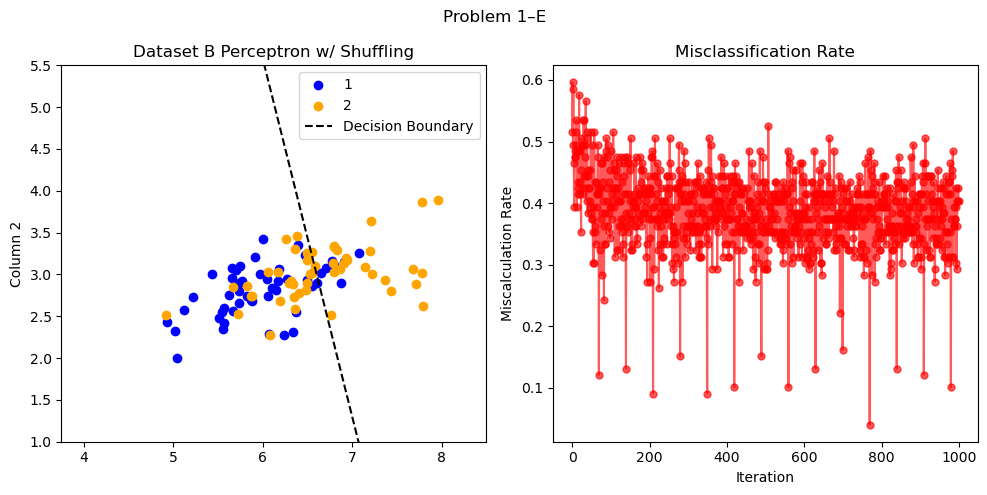

In [8]:
# initialize data
X, y = X_B.copy(), y_B.copy()
seed=7

# run model
weights, errors = myPerceptron(X, y, shuffle=True, random_seed=seed)
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2

# set up figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot dataset
ax[0].scatter(dfB[dfB['Label']==-1]['C1'], dfB[dfB['Label']==-1]['C2'], c='blue', label='1') # plot values labeled -1
ax[0].scatter(dfB[dfB['Label']==1]['C1'], dfB[dfB['Label']==1]['C2'], c='orange', label='2') # plot values labeled 1
# plot decision boundary
ax[0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[0].set_ylabel('Column 2')
ax[0].legend()
ax[0].set_title('Dataset B Perceptron w/ Shuffling')
ax[0].set_xlim(x1_min, x1_max)
ax[0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[1].plot(errors, marker='o', linestyle='-', color='red', markersize=5, alpha=0.65, )
ax[1].set_ylabel('Miscalculation Rate')
ax[1].set_xlabel('Iteration')
ax[1].set_title('Misclassification Rate')

plt.suptitle('Problem 1–E')
plt.tight_layout()
plt.show()

#### 1-F: PLA on Dataset B Best vs Last

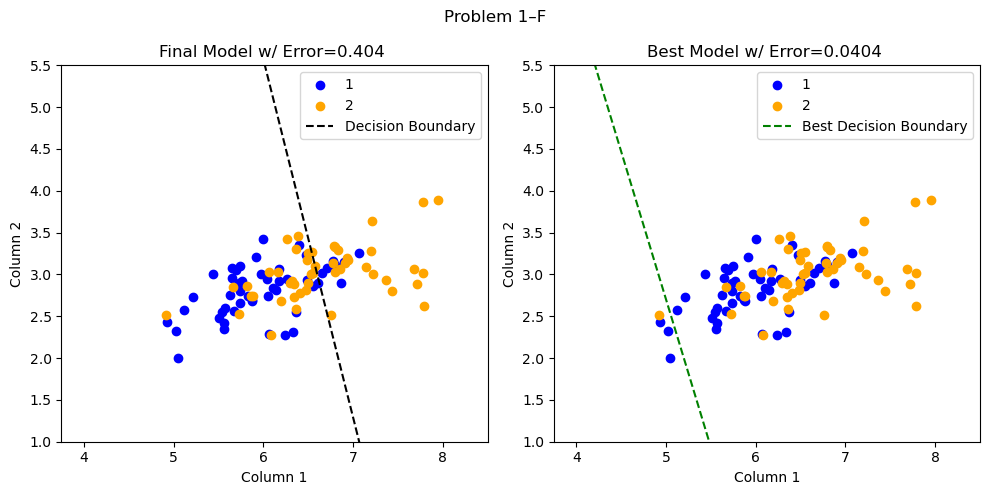

In [11]:
# initialize data
X, y = X_B.copy(), y_B.copy()

# set up figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# run NON pocket model
weights, errors = myPerceptron(X, y, shuffle=True, random_seed=seed)
intercept, w_1, w_2 = weights[0], weights[1], weights[2]
final_err = errors[len(errors)-1]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2

# plot dataset
ax[0].scatter(dfB[dfB['Label']==-1]['C1'], dfB[dfB['Label']==-1]['C2'], c='blue', label='1') # plot values labeled -1
ax[0].scatter(dfB[dfB['Label']==1]['C1'], dfB[dfB['Label']==1]['C2'], c='orange', label='2') # plot values labeled 1
# plot decision boundary
ax[0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[0].set_ylabel('Column 2')
ax[0].set_xlabel('Column 1')
ax[0].legend()
ax[0].set_title(f'Final Model w/ Error={round(final_err,4)} ')


# run POCKET model
best_weights, best_error = myPerceptron(X, y, shuffle=True, pocket=True, random_seed=seed)
best_intercept, best_w_1, best_w_2 = best_weights[0], best_weights[1], best_weights[2]
# def best decision boundary line
best_x2_vals = -(best_w_1*x1_vals + best_intercept) / best_w_2

# best model
ax[1].scatter(dfB[dfB['Label']==-1]['C1'], dfB[dfB['Label']==-1]['C2'], c='blue', label='1') # plot values labeled -1
ax[1].scatter(dfB[dfB['Label']==1]['C1'], dfB[dfB['Label']==1]['C2'], c='orange', label='2') # plot values labeled 1
# decision boundary
ax[1].plot(x1_vals, best_x2_vals, 'g--', label='Best Decision Boundary')
ax[1].set_ylabel('Column 2')
ax[1].set_xlabel('Column 1')
ax[1].legend()
ax[1].set_title(f'Best Model w/ Error={round(best_error,4)} ')

# Set the same axis limits
for a in ax:
    a.set_xlim(x1_min, x1_max)
    a.set_ylim(x2_min, x2_max)

plt.suptitle('Problem 1–F')
plt.tight_layout()
plt.show()

### Problem 2
#### 2-B: MSE PLA on Dataset B

MSE Model training took 1.1865 seconds
Regular Model training took 0.0037 seconds


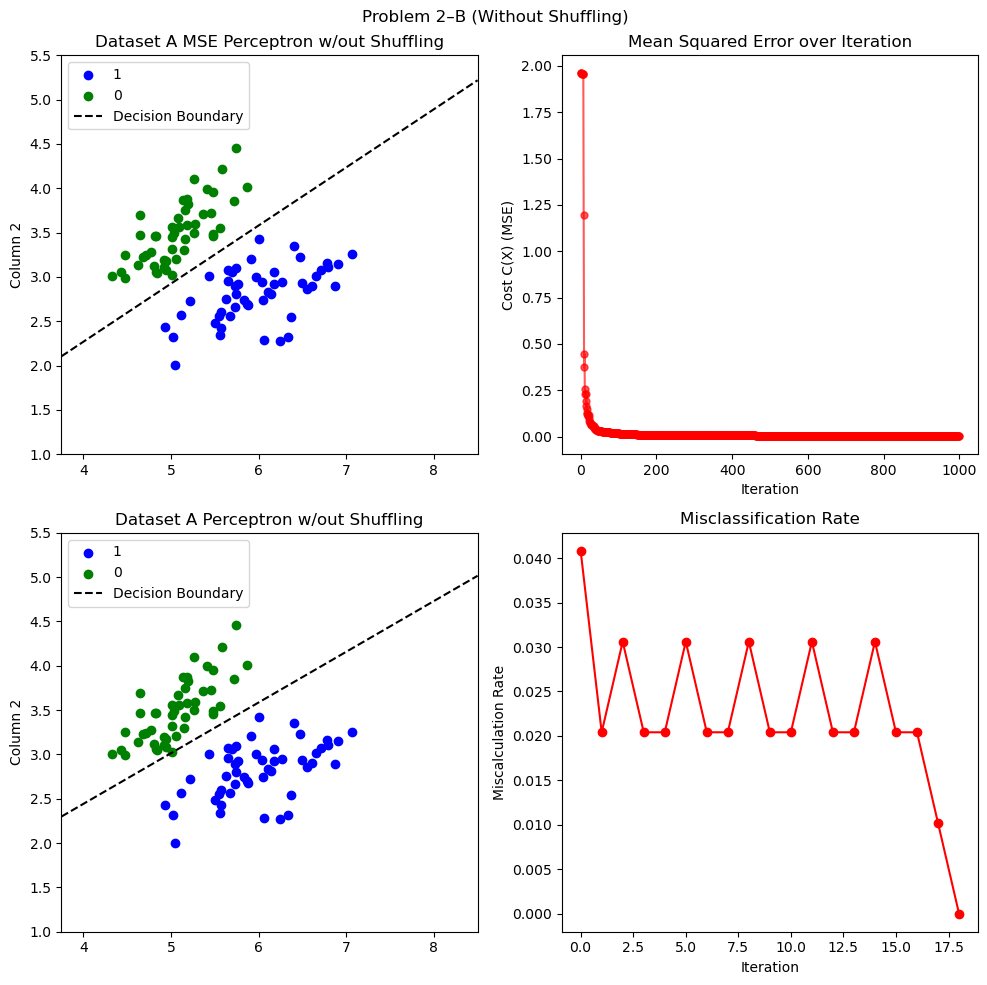

In [38]:
# initialize data
X, y = X_A.copy(), y_A.copy()

# run MSE model
start_time = time.perf_counter()
weights, average_costs = myPerceptron(X, y, eta=0.1, max_iters=1000, shuffle=False, mse_loss=True)
end_time = time.perf_counter()
print(f"MSE Model training took {end_time - start_time:.4f} seconds")
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2

# set up figure
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# plot dataset
ax[0,0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
ax[0,0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')
# plot decision boundary
ax[0,0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[0,0].set_ylabel('Column 2')
ax[0,0].legend()
ax[0,0].set_title('Dataset A MSE Perceptron w/out Shuffling')
ax[0,0].set_xlim(x1_min, x1_max)
ax[0,0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[0,1].plot(average_costs, marker='o', linestyle='-', color='red', markersize=5, alpha=0.65, )
ax[0,1].set_ylabel('Cost C(X) (MSE)')
ax[0,1].set_xlabel('Iteration')
ax[0,1].set_title('Mean Squared Error over Iteration')


# run regular model
start_time = time.perf_counter()
weights, errors = myPerceptron(X, y, shuffle=False, eta=0.1, random_seed=seed)
end_time = time.perf_counter()
print(f"Regular Model training took {end_time - start_time:.4f} seconds")
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2


# plot dataset
ax[1,0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
ax[1,0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')
# plot decision boundary
ax[1,0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[1,0].legend()
ax[1,0].set_ylabel('Column 2')
ax[1,0].set_title('Dataset A Perceptron w/out Shuffling')
ax[1,0].set_xlim(x1_min, x1_max)
ax[1,0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[1,1].plot(errors, marker='o', linestyle='-', color='red')
ax[1,1].set_ylabel('Miscalculation Rate')
ax[1,1].set_xlabel('Iteration')
ax[1,1].set_title('Misclassification Rate')

plt.suptitle('Problem 2–B (Without Shuffling)')
plt.tight_layout()
plt.show()

MSE Model training took 1.2289 seconds
Regular Model training took 0.0025 seconds


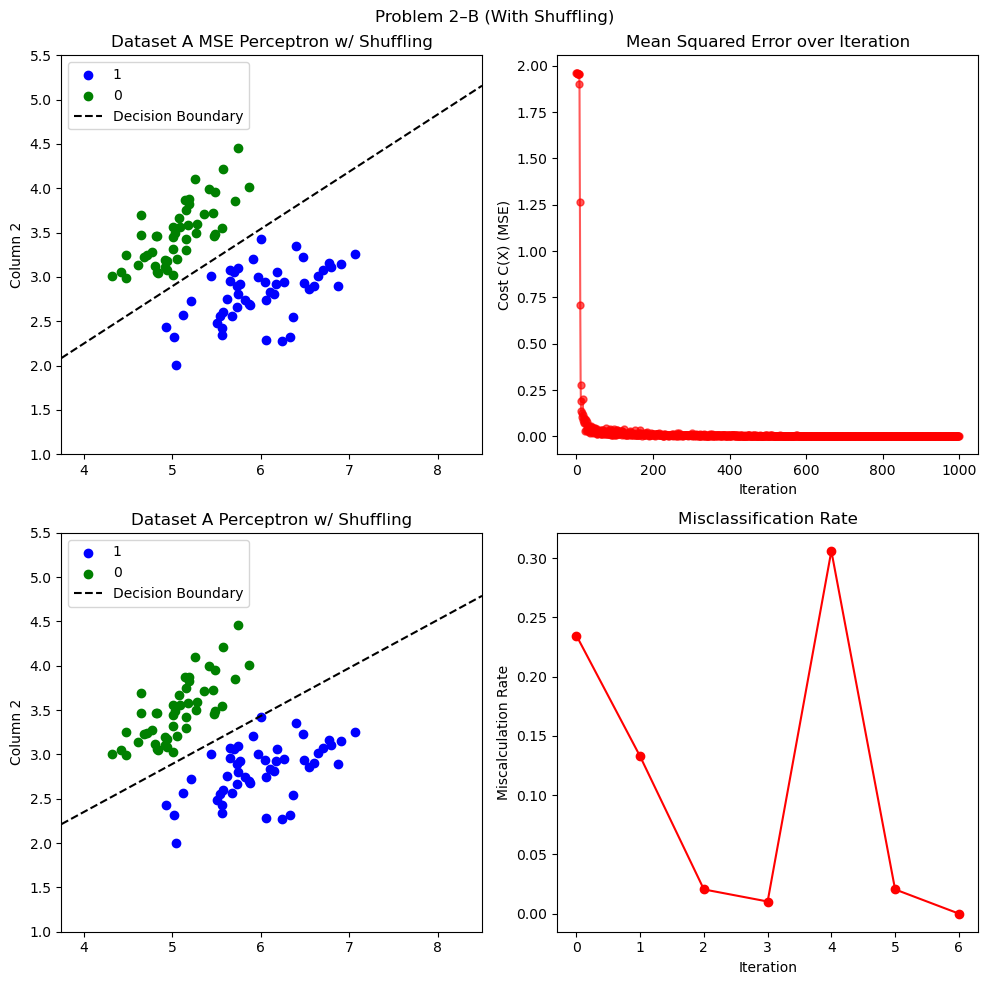

In [37]:
# initialize data
X, y = X_A.copy(), y_A.copy()
seed = 42
# run MSE model
start_time = time.perf_counter()
weights, average_costs = myPerceptron(X, y, eta=0.1, max_iters=1000, shuffle=True, mse_loss=True)
end_time = time.perf_counter()
print(f"MSE Model training took {end_time - start_time:.4f} seconds")
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2

# set up figure
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# plot dataset
ax[0,0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
ax[0,0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')
# plot decision boundary
ax[0,0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[0,0].set_ylabel('Column 2')
ax[0,0].legend()
ax[0,0].set_title('Dataset A MSE Perceptron w/ Shuffling')
ax[0,0].set_xlim(x1_min, x1_max)
ax[0,0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[0,1].plot(average_costs, marker='o', linestyle='-', color='red', markersize=5, alpha=0.65, )
ax[0,1].set_ylabel('Cost C(X) (MSE)')
ax[0,1].set_xlabel('Iteration')
ax[0,1].set_title('Mean Squared Error over Iteration')


# run regular model
start_time = time.perf_counter()
weights, errors = myPerceptron(X, y, shuffle=True, eta=0.1, random_seed=seed)
end_time = time.perf_counter()
print(f"Regular Model training took {end_time - start_time:.4f} seconds")
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2


# plot dataset
ax[1,0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
ax[1,0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')
# plot decision boundary
ax[1,0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[1,0].legend()
ax[1,0].set_ylabel('Column 2')
ax[1,0].set_title('Dataset A Perceptron w/ Shuffling')
ax[1,0].set_xlim(x1_min, x1_max)
ax[1,0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[1,1].plot(errors, marker='o', linestyle='-', color='red')
ax[1,1].set_ylabel('Miscalculation Rate')
ax[1,1].set_xlabel('Iteration')
ax[1,1].set_title('Misclassification Rate')

plt.suptitle('Problem 2–B (With Shuffling)')
plt.tight_layout()
plt.show()



#### 2-C: MSE PLA on Dataset B

MSE Model training took 1.0096 seconds
Regular Model training took 0.5378 seconds


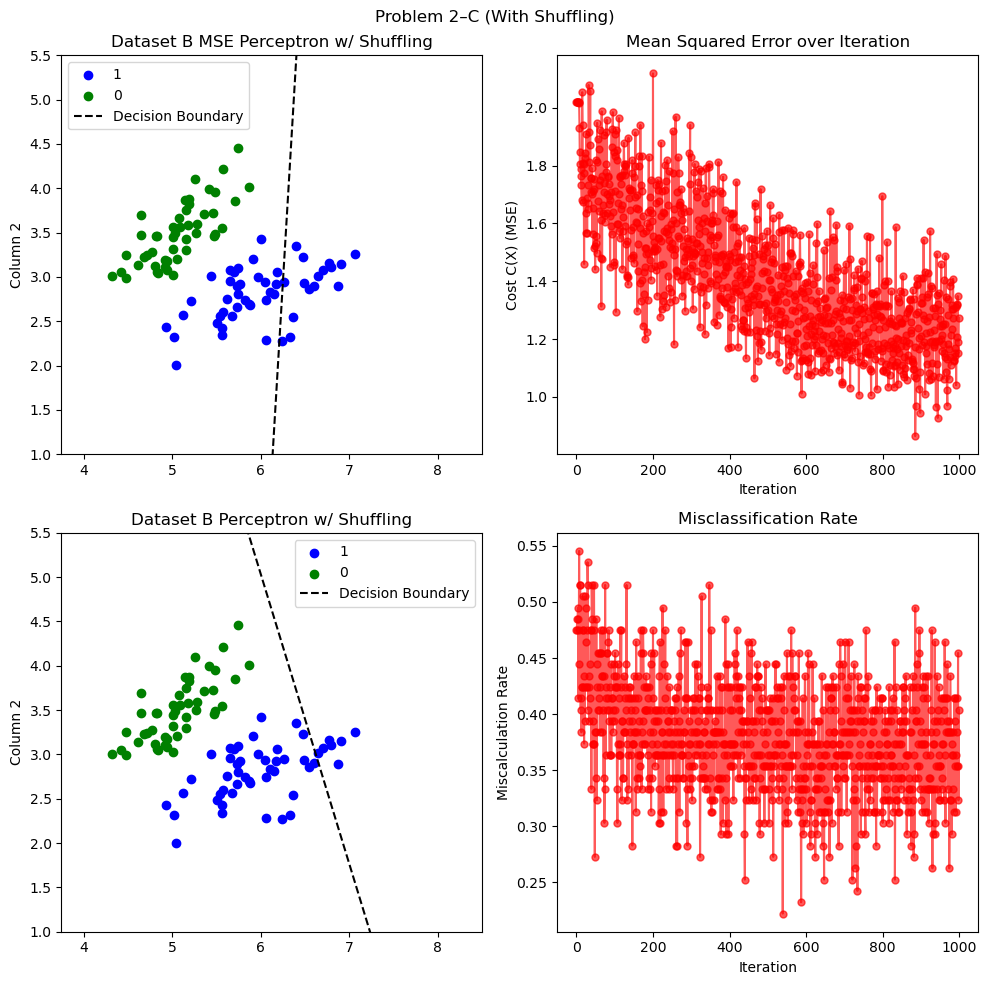

In [41]:
# initialize data
X, y = X_B.copy(), y_B.copy()
seed = 42

# run MSE model
start_time = time.perf_counter()
weights, average_costs = myPerceptron(X, y, eta=0.1, max_iters=1000, shuffle=True, mse_loss=True)
end_time = time.perf_counter()
print(f"MSE Model training took {end_time - start_time:.4f} seconds")
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2

# set up figure
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# plot dataset
ax[0,0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
ax[0,0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')
# plot decision boundary
ax[0,0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[0,0].set_ylabel('Column 2')
ax[0,0].legend()
ax[0,0].set_title('Dataset B MSE Perceptron w/ Shuffling')
ax[0,0].set_xlim(x1_min, x1_max)
ax[0,0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[0,1].plot(average_costs, marker='o', linestyle='-', color='red', markersize=5, alpha=0.65, )
ax[0,1].set_ylabel('Cost C(X) (MSE)')
ax[0,1].set_xlabel('Iteration')
ax[0,1].set_title('Mean Squared Error over Iteration')

# run regular model
start_time = time.perf_counter()
weights, errors = myPerceptron(X, y, shuffle=True, eta=0.1, max_iters=1000,random_seed=seed)
end_time = time.perf_counter()
print(f"Regular Model training took {end_time - start_time:.4f} seconds")
intercept, w_1, w_2 = weights[0], weights[1], weights[2]

# def decision boundary line: w1*x1 + w2*x2 + b = 0
x1_vals = np.linspace(x1_min, x1_max, 100)
x2_vals = -(w_1*x1_vals + intercept) / w_2

# plot dataset
ax[1,0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1')
ax[1,0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0')
# plot decision boundary
ax[1,0].plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')
ax[1,0].legend()
ax[1,0].set_ylabel('Column 2')
ax[1,0].set_title('Dataset B Perceptron w/ Shuffling')
ax[1,0].set_xlim(x1_min, x1_max)
ax[1,0].set_ylim(x2_min, x2_max)

# plot misclassification rate
ax[1,1].plot(errors, marker='o', linestyle='-', color='red', markersize=5, alpha=0.65, )
ax[1,1].set_ylabel('Miscalculation Rate')
ax[1,1].set_xlabel('Iteration')
ax[1,1].set_title('Misclassification Rate')

plt.suptitle('Problem 2–C (With Shuffling)')
plt.tight_layout()
plt.show()